<a href="https://colab.research.google.com/github/BenRoche18/Im2Calories/blob/master/food_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import shutil
from tqdm.autonotebook import tqdm

**Enable GPU**

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


**Declare parameters**

In [3]:
ROOT_DIR = os.path.dirname(os.getcwd())

IMAGE_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001

SKIP_TRANSFER_LEARNING = True

# Input data

**Download Food101 dataset**

I will be using the labelled food-101 dataset that includes 101 different classes each containing 1000 images. If given directory not found then dataset is downloaded, extracted and the dataset is split into training and test images.

In [4]:
FOOD101_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food101")
TRAIN_DIR = os.path.join(FOOD101_DIR, "train")
VAL_DIR = os.path.join(FOOD101_DIR, "test")

if not os.path.exists(FOOD101_DIR):
  print("Downloading Food-101 dataset... ", end="")
  !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
  print("Done")


  print("Extracting data... ", end="")
  !tar xzvf food-101.tar.gz
  print("Done")
    
    
  print("Spliting dataset... ", end="")
  for split in ["train", "test"]:
    images = {}
    
    # extract image filenames
    with open(os.path.join(FOOD101_DIR, "meta", split+".txt"), 'r') as file:
      for path in file.readlines():
        path = path.strip()
        food_class, food_id = path.split('/')
        images.setdefault(food_class, []).append(food_id)
        
    # copy images into split directory
    for food_class in images.keys():
      # make class directory
      os.makedirs(os.path.join(FOOD101_DIR, split, food_class))

      # populate class directory with images
      for food_id in images[food_class]:
        src = os.path.join(FOOD101_DIR, "images", food_class, food_id+".jpg")
        dest = os.path.join(FOOD101_DIR, split, food_class, food_id+".jpg")
        shutil.copy(src, dest)
  print("Done")

**Format training images**

In [5]:
train_transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_raw = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
train_size = len(train_raw)

train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True)

class_names = train_raw.classes

**Format validation images**

In [6]:
val_transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_raw = torchvision.datasets.ImageFolder(VAL_DIR, transform=val_transform)
val_size = len(val_raw)

val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE)

**Show example images from dataset**

I have randomly selected and displayed 20 images from the training dataset along with their corresponding class.

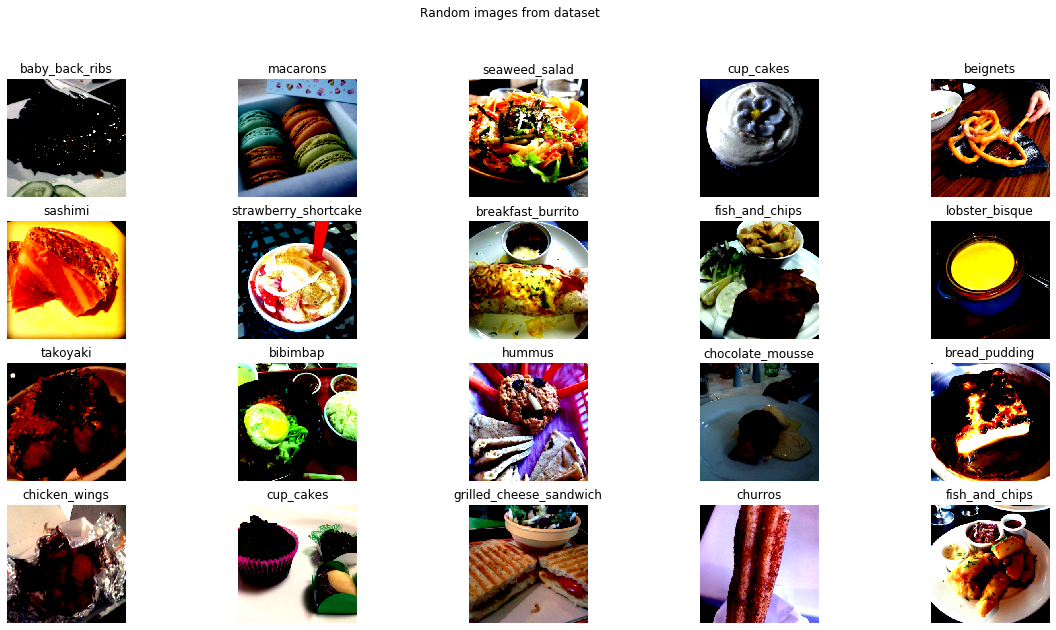

In [7]:
cols, rows = 5, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle("Random images from dataset")

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  # randomly sellect image from dataset
  j = np.random.randint(train_size)
  img = train_raw[j][0].numpy()
  img = np.transpose(img, (1,2,0))
  img = img * (0.485, 0.456, 0.406) + (0.229, 0.224, 0.225)

  plt.title(class_names[train_raw[j][1]])
  plt.axis("off")
  img = np.clip(img, 0, 1)
  plt.imshow(img, interpolation="nearest")
plt.show()

# Model

**Fetch Model**

In order to train the food classifier I will initially use transfer learning from a pretrained InceptionV3 model. This involves replacing the classification head with a 101-way dense layer and freezing all other layers.

In [ ]:
print("Fetching pretrained model... ", end="")
# fetch pre-trained feature extractor
model = torchvision.models.inception_v3(pretrained=True)

if not SKIP_TRANSFER_LEARNING:
    # freeze feature extractor
    for param in model.parameters():
      param.requires_grad = False

# handle auxilary net
num_features = model.AuxLogits.fc.in_features
model.AuxLogits.fc = torch.nn.Linear(num_features, 101)

# handle primary net
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 101)

model = model.to(device)
print("done")

Fetching pretrained model... 

# Training via transfer learning

**Declare optimizer and loss function**

In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
loss_func = torch.nn.CrossEntropyLoss()

**Train model**

In [ ]:
statistics = {
    "accuracy": [],
    "val_accuracy": []
}

def train():
  best_acc = 0.0
  best_model_weights = None

  for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    i = 0
    with tqdm(total=train_size) as progress_bar:
        progress_bar.set_description("Epoch {}/{}".format(epoch, EPOCHS))
        for (images, labels) in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          # reset the parameter gradients
          optimizer.zero_grad()

          # fit images on model
          outputs, aux_outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          loss1 = loss_func(outputs, labels)
          loss2 = loss_func(aux_outputs, labels)
          loss = loss1 + 0.4 * loss2

          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          running_corrects += torch.sum(predictions == labels.data)

          i += 1
          progress_bar.update(BATCH_SIZE)
          progress_bar.set_postfix(epoch_loss=running_loss/(i*BATCH_SIZE), epoch_acc=running_corrects.double().item()/(i*BATCH_SIZE))
    
    # calculate statistics
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    
    # print statistics
    print("Training Loss: {:.4f}, Acc: {:.4f}".format(epoch_loss, epoch_acc))
    statistics['accuracy'].append(epoch_acc)
    
    val_loss, val_acc = validate()

    # save best model seen
    if val_acc > best_acc:
      best_acc = epoch_acc
      best_model_weights = copy.deepcopy(model.state_dict())

    # print statistics
    print("Validation Loss: {:.4f}, Acc: {:.4f}\n".format(val_loss, val_acc))
    statistics['val_accuracy'].append(val_acc)
    
  # reinstantiate best seen weights
  model.load_state_dict(best_model_weights)

  print("DONE")


def validate():
  model.eval()
  running_loss = 0.0
  running_corrects = 0

  for (images, labels) in val_loader:
    images = images.to(device)
    labels = labels.to(device)

    # fit images on model
    with torch.no_grad():
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      loss = loss_func(outputs, labels)

    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(predictions == labels.data)

  # calculate statistics
  val_loss = running_loss / val_size
  val_acc = running_corrects.double() / val_size

  return val_loss, val_acc

if not SKIP_TRANSFER_LEARNING:
    train()

**Save model**

In [ ]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", "transfer_learning_v1.pt")

if not SKIP_TRANSFER_LEARNING:
    torch.save(model.state_dict(), MODEL_PATH)

**Evaluate transfer learning**

In [ ]:
if not SKIP_TRANSFER_LEARNING:
    plt.plot(statistics['accuracy'], label='accuracy')
    plt.plot(statistics['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend(loc='lower right')

# Training via fine-tuning

In [ ]:
if SKIP_TRANSFER_LEARNING:
    print("Loading transfer learning weights...", end="")
    model.load_state_dict(torch.load(MODEL_PATH))
    print("done")

**Unfreeze layers in model**

In [ ]:
if not SKIP_TRANSFER_LEARNING:
    for param in model.parameters():
        param.requires_grad = True

**Train model**

In [ ]:
statistics = {
    "accuracy": [],
    "val_accuracy": []
}

train()

**Save model**

In [ ]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", "fine_tuning_v1.pt")
torch.save(model.state_dict(), MODEL_PATH)

# Evaluate

In [ ]:
plt.plot(statistics['accuracy'], label='accuracy')
plt.plot(statistics['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.legend(loc='lower right')